In [5]:
import numpy as np
import cupy as cp
import ray
import astropy.units as u
from astropy.io import fits
from IPython.display import clear_output
import time
from pathlib import Path
from matplotlib.patches import Circle
from importlib import reload

# import warnings
# warnings.filterwarnings("ignore")

import poppy

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import cgi_phasec_poppy as cgi
reload(cgi)

import misc_funs as misc

iwa = 3
owa = 9

data_dir = cgi.data_dir

# dm1_flat = 2*fits.getdata(data_dir/'dm-acts'/'flatmaps'/'hlc_flattened_dm1.fits')
# dm2_flat = 2*fits.getdata(data_dir/'dm-acts'/'flatmaps'/'hlc_flattened_dm2.fits')

In [2]:
poppy.conf.use_cupy = True
poppy.conf.use_mkl = True
poppy.conf.use_fftw = True

# Test monochromatic PSFs.

Propagating wavelength 730.000 nm.


c:\users\kian\documents\src\poppy\poppy\geometry.py:215: UserWarning: filled_circle_aa may not yield exact results for grey pixels when pixel scale <1
  warnings.warn('filled_circle_aa may not yield exact results for grey pixels when pixel scale <1')
c:\users\kian\documents\src\poppy\poppy\geometry.py:215: UserWarning: filled_circle_aa may not yield exact results for grey pixels when pixel scale <1
  warnings.warn('filled_circle_aa may not yield exact results for grey pixels when pixel scale <1')


PSF calculated in 0.936s


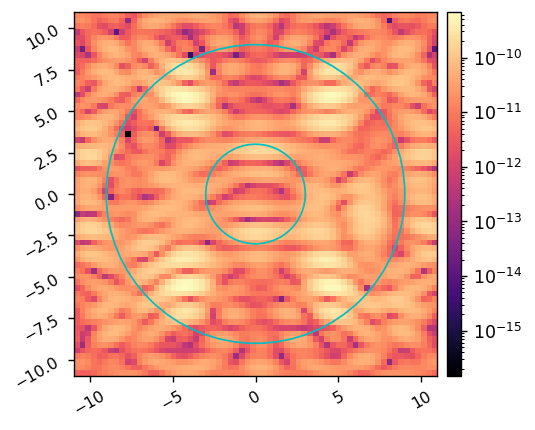

Saved data to:  C:\Users\Kian\Documents\data-files\roman-cgi-phasec-data\spc-spec_psf_gpu.fits


In [7]:
reload(cgi)
mode = cgi.CGI(cgi_mode='spc-spec', 
               use_pupil_defocus=True, use_opds=False)

wf = mode.calc_psf(quiet=False)
psf = np.abs(wf)**2

patches = [Circle((0, 0), iwa, color='c', fill=False), Circle((0, 0), owa, color='c', fill=False)]
misc.imshow1(psf, lognorm=True, pxscl=mode.psf_pixelscale_lamD, patches=patches)

if poppy.accel_math._USE_CUPY:
    misc.save_fits(data_dir/'spc-spec_psf_gpu.fits', psf, header={'PIXELSCL':mode.psf_pixelscale_lamD})
else:
    misc.save_fits(data_dir/'spc-spec_psf_cpu.fits', psf, header={'PIXELSCL':mode.psf_pixelscale_lamD})

In [15]:
%%timeit
wf = hlc.calc_psf(quiet=True)

299 ms ± 778 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Propagating wavelength 730.000 nm.


c:\users\kian\documents\src\poppy\poppy\geometry.py:215: UserWarning: filled_circle_aa may not yield exact results for grey pixels when pixel scale <1
  warnings.warn('filled_circle_aa may not yield exact results for grey pixels when pixel scale <1')
c:\users\kian\documents\src\poppy\poppy\geometry.py:215: UserWarning: filled_circle_aa may not yield exact results for grey pixels when pixel scale <1
  warnings.warn('filled_circle_aa may not yield exact results for grey pixels when pixel scale <1')


PSF calculated in 1.080s


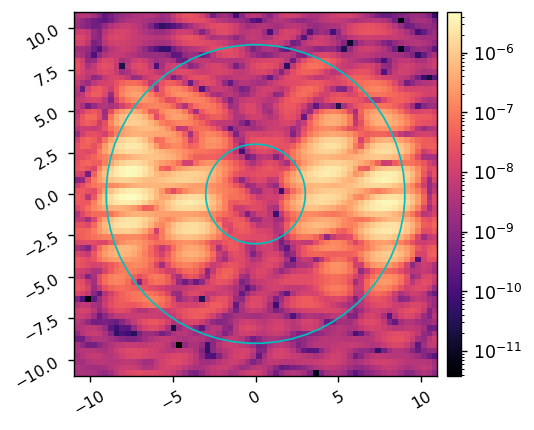

Saved data to:  C:\Users\Kian\Documents\data-files\roman-cgi-phasec-data\spc-spec_opds_psf_gpu.fits


In [8]:
mode = cgi.CGI(cgi_mode='spc-spec',
               use_pupil_defocus=True, use_opds=True)

# mode.set_dm1(dm1_flat)
# mode.set_dm2(dm2_flat)

wf = mode.calc_psf(quiet=False)
psf = np.abs(wf)**2

patches = [Circle((0, 0), iwa, color='c', fill=False), Circle((0, 0), owa, color='c', fill=False)]
misc.imshow1(psf, lognorm=True, pxscl=mode.psf_pixelscale_lamD, patches=patches)

if poppy.accel_math._USE_CUPY:
    misc.save_fits(data_dir/'spc-spec_opds_psf_gpu.fits', psf, header={'PIXELSCL':mode.psf_pixelscale_lamD})
else:
    misc.save_fits(data_dir/'spc-spec_opds_psf_cpu.fits', psf, header={'PIXELSCL':mode.psf_pixelscale_lamD})

In [22]:
%%timeit
wf = mode_opds.calc_psf(quiet=True)

349 ms ± 1.36 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Test broadband PSFs with GPU parallelization.

### Create the actors to calculate each individual PSF/image with ray.remote() actors.

num_gpus can be set to whatever fractional GPU the user desires

In [10]:
wavelength_c = 725e-9*u.m

nlam = 3
bandwidth = 0.15
minlam = wavelength_c * (1 - bandwidth/2)
maxlam = wavelength_c * (1 + bandwidth/2)
wavelengths = np.linspace( minlam, maxlam, nlam )

kwargs = {'cgi_mode':'spc-spec',
          'use_pupil_defocus':True,
          'use_opds':False}
actors = []
for i in range(nlam):
    actors.append(ray.remote(cgi.CGI).options(num_gpus=1/nlam).remote(wavelength=wavelengths[i], **kwargs))

### Calculate each image by calling the remote function of each actor. 

 pid=11008) c:\users\kian\documents\src\poppy\poppy\geometry.py:215: UserWarning: filled_circle_aa may not yield exact results for grey pixels when pixel scale <1
 pid=11008)   warnings.warn('filled_circle_aa may not yield exact results for grey pixels when pixel scale <1')
 pid=11008) c:\users\kian\documents\src\poppy\poppy\geometry.py:215: UserWarning: filled_circle_aa may not yield exact results for grey pixels when pixel scale <1
 pid=11008)   warnings.warn('filled_circle_aa may not yield exact results for grey pixels when pixel scale <1')
 pid=11404) c:\users\kian\documents\src\poppy\poppy\geometry.py:215: UserWarning: filled_circle_aa may not yield exact results for grey pixels when pixel scale <1
 pid=11404)   warnings.warn('filled_circle_aa may not yield exact results for grey pixels when pixel scale <1')
 pid=11404) c:\users\kian\documents\src\poppy\poppy\geometry.py:215: UserWarning: filled_circle_aa may not yield exact results for grey pixels when pixel scale <1
 pid=11404) 

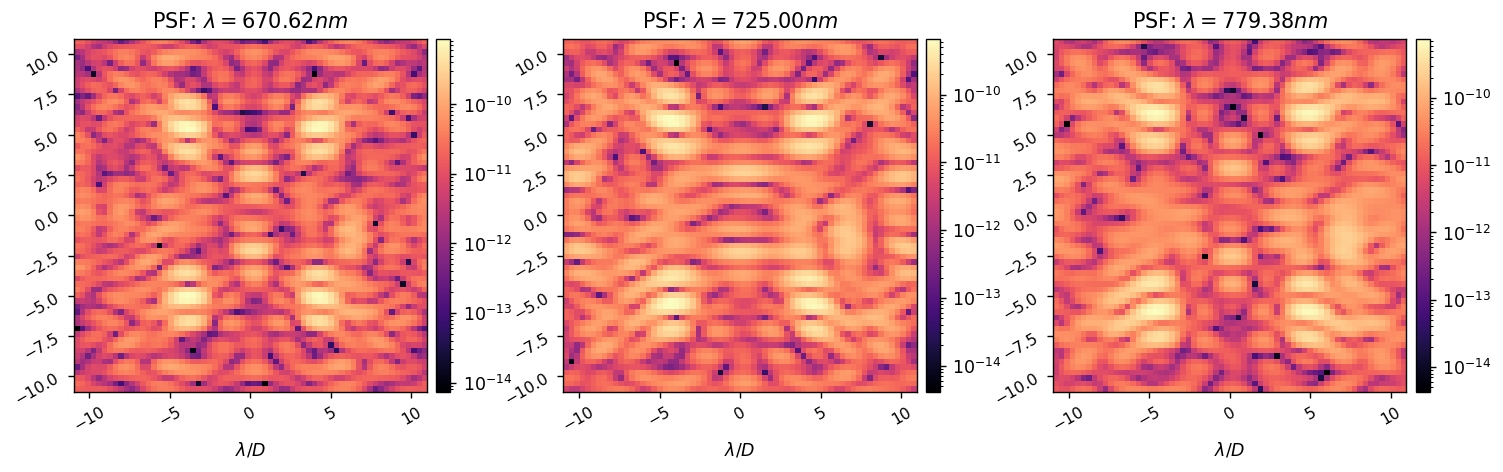

In [16]:
pending_ims = []
for i in range(len(actors)):
#     actors[i].set_dm1.remote(dm1_flat) # set the DM state for each actor in this loop
#     actors[i].set_dm2.remote(dm2_flat)
    future_ims = actors[i].snap.remote()
    pending_ims.append(future_ims)
ims = ray.get(pending_ims)
reload(misc)

misc.imshow3(ims[0], ims[1], ims[2], 
             'PSF: $\lambda={:.2f}$'.format(wavelengths[0].to(u.nm)), 
             'PSF: $\lambda={:.2f}$'.format(wavelengths[1].to(u.nm)),
             'PSF: $\lambda={:.2f}$'.format(wavelengths[2].to(u.nm)),
             pxscl=mode.psf_pixelscale_lamD, xlabel='$\lambda/D$',
             lognorm=True)

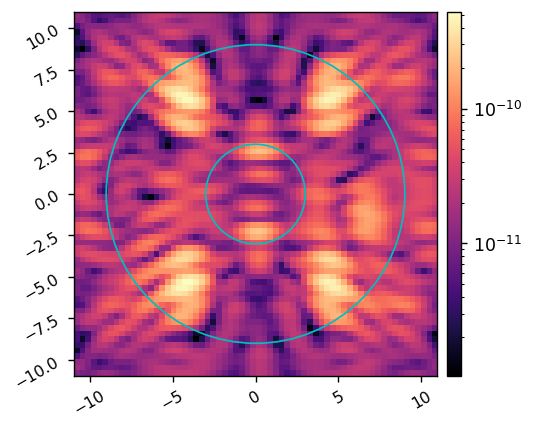

Saved data to:  C:\Users\Kian\Documents\data-files\roman-cgi-phasec-data\spc-spec_psf_broad_gpu.fits


In [13]:
psf_broad = np.sum(ims, axis=0)/nlam

patches = [Circle((0, 0), iwa, color='c', fill=False), Circle((0, 0), owa, color='c', fill=False)]
misc.imshow1(psf_broad, lognorm=True, pxscl=mode.psf_pixelscale_lamD, patches=patches)

if poppy.accel_math._USE_CUPY:
    misc.save_fits(data_dir/'spc-spec_psf_broad_gpu.fits', psf_broad, header={'PIXELSCL':mode.psf_pixelscale_lamD})
else:
    misc.save_fits(data_dir/'spc-spec_psf_broad_cpu.fits', psf_broad, header={'PIXELSCL':mode.psf_pixelscale_lamD})